## Linear Regression of Active Ligand Yields

The following was used to develop a linear regression model to predict the observed yields of active ligands in the dataset. To keep the numbers of features used by the regressor, all combinations of two unique features were screened to find the best combination. Each combination was evaluated with the train R2/RMSE score and LOO cross-validation R2/RMSE. The best combination was then used to train the final model.

As well, SHAP values were calculated to determine individual feature importance in the model.

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv("data/ligand-qsar/alkylamine-ligand-modeling.tsv", sep="\t")
df = df[df["product_1_yield"] > 16].reset_index(drop=True)

scaler = StandardScaler()
X = df.drop(columns=["ligand_1_name", "product_1_yield"])
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

y = df["product_1_yield"]

In [5]:
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import KFold, LeaveOneOut, cross_val_predict

sns.set_theme(rc={"figure.figsize": (5, 5), "figure.dpi": 150}, style="ticks", font_scale=1.2)


def evaluate_model(clf, X, y):
    """Evaluate a model using cross-validation."""
    clf.fit(X, y)
    print(X.columns)
    train_preds = clf.predict(X)
    r2 = metrics.r2_score(y, train_preds)
    rmse = metrics.root_mean_squared_error(y, train_preds)
    print(f"R^2: {r2:0.2f}")
    print(f"RMSE: {rmse:0.2f}")
    print()

    loo = LeaveOneOut()
    rmses = []
    maes = []
    r2s = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        rmses.append(metrics.root_mean_squared_error(y_test, preds))
        maes.append(metrics.mean_absolute_error(y_test, preds))
        r2s.append(metrics.r2_score(y_test, preds))
    loo_rmse = round(np.mean(rmses), 2)
    loo_mae = round(np.mean(maes), 2)
    loo_r2 = round(np.mean(r2s), 2)

    cv_preds = cross_val_predict(clf, X, y, cv=loo)
    loo_r2 = metrics.r2_score(y, cv_preds)

    print(f"LOO RMSE: {loo_rmse:0.2f}")
    print(f"LOO MAE: {loo_mae:0.2f}")
    print(f"LOO R^2: {loo_r2:0.2f}")
    print()

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    kfold_rmses = []
    kfold_maes = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        kfold_rmses.append(metrics.root_mean_squared_error(y_test, preds))
        kfold_maes.append(metrics.mean_absolute_error(y_test, preds))
    kfold_rmse = round(np.mean(kfold_rmses), 2)
    kfold_mae = round(np.mean(kfold_maes), 2)

    print(f"K-Fold RMSE: {kfold_rmse:0.2f}")
    print(f"K-Fold MAE: {kfold_mae:0.2f}")
    kfold_cv_preds = cross_val_predict(clf, X, y, cv=kfold)
    kfold_r2 = metrics.r2_score(y, kfold_cv_preds)
    print(f"K-Fold R^2: {kfold_r2:0.2f}")

    fig, ax = plt.subplots()
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.plot([0, 100], [0, 100], color="grey", linestyle="--")

    sns.scatterplot(x=y, y=train_preds, s=200, ax=ax, color="#841E5A")
    ax.set_xlabel("Observed Yield (%)")
    ax.set_ylabel("Predicted Yield (%)")
    ax.set_title("Active Ligands Linear Regression", fontsize=16)

    ax.text(
        5,
        95,
        f"R$^2$: {r2:0.2f}\nRMSE: {rmse:0.2f}\nLOO R$^2$: {loo_r2:.2f}\nLOO RMSE: {loo_rmse:.2f}",
        fontsize=12,
        color="black",
        ha="left",
        va="top",
        bbox=dict(
            facecolor="white",
            alpha=1.0,
            edgecolor="lightgrey",
            boxstyle="round,pad=0.5,rounding_size=0.2",
        ),
    )

    for i, txt in enumerate(df["ligand_1_name"]):
        ax.annotate(
            txt,
            (y[i], train_preds[i]),
            fontsize=12,
            ha="right",
            va="bottom",
            path_effects=[pe.withStroke(linewidth=3, foreground="white")],
        )

    coefficients = sorted(zip(X.columns, clf.coef_), key=lambda x: abs(x[1]), reverse=True)

    if len(coefficients) == 1:
        textstr = f"Feature 1: {coefficients[0][0]} ({coefficients[0][1]:.2f})"
    elif len(coefficients) == 2:
        textstr = "\n".join(
            (
                f"Feature 1: {coefficients[0][0]} ({coefficients[0][1]:.2f})",
                f"Feature 2: {coefficients[1][0]} ({coefficients[1][1]:.2f})",
            )
        )
    else:
        textstr = "\n".join(
            (
                f"Feature 1: {coefficients[0][0]} ({coefficients[0][1]:.2f})",
                f"Feature 2: {coefficients[1][0]} ({coefficients[1][1]:.2f})",
                f"Feature 3: {coefficients[2][0]} ({coefficients[2][1]:.2f})",
            )
        )

    ax.text(
        50,
        -18,
        textstr,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="center",
    )

    plt.show()

In [6]:
from itertools import combinations

from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

run = True


def evaluate_combination(features: tuple):
    """Evaluate a combination of features."""
    clf = LinearRegression()
    clf.fit(X[list(features)], y)
    preds = clf.predict(X[list(features)])
    r2 = round(metrics.r2_score(y, preds), 2)
    rmse = round(metrics.root_mean_squared_error(y, preds), 2)

    if r2 < 0.8:
        return (features, r2, rmse, 0, 0)

    kfold = LeaveOneOut()
    kfold_rmses = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train[list(features)], y_train)
        preds = clf.predict(X_test[list(features)])
        kfold_rmses.append(metrics.root_mean_squared_error(y_test, preds))
    kfold_rmse = round(np.mean(kfold_rmses), 2)

    cv_preds = cross_val_predict(clf, X[list(features)], y, cv=kfold)
    kfold_r2 = round(metrics.r2_score(y, cv_preds), 2)
    if kfold_r2 < 0:
        return (features, r2, rmse, 0, kfold_rmse)

    return (features, r2, rmse, kfold_r2, kfold_rmse)


combinations_list = list(combinations(X.columns, 2))

print(f"Number of combinations: {len(combinations_list)}")

if run:
    results = Parallel(n_jobs=-1)(delayed(evaluate_combination)(features) for features in tqdm(combinations_list))

    results = sorted(results, key=lambda x: x[3], reverse=True)
    for features, r2, rmse, kfold_r2, kfold_rmse in results[:10]:
        print(f"Features: {features}, R2: {r2}, RMSE: {rmse},  LOO R2: {kfold_r2}, LOO RMSE: {kfold_rmse}")

Number of combinations: 11628


100%|██████████| 11628/11628 [00:23<00:00, 493.59it/s] 


Features: ('min_fukui_f_minus_carb_oh', 'min_bond_order_Pd_C'), R2: 0.93, RMSE: 5.65,  LOO R2: 0.88, LOO RMSE: 5.67
Features: ('min_partial_charge_carbonyl_oxygen', 'max_distance_Pd_P'), R2: 0.92, RMSE: 5.95,  LOO R2: 0.85, LOO RMSE: 6.74
Features: ('min_partial_charge_carbonyl_oxygen', 'min_fukui_f_minus_carb_oh'), R2: 0.93, RMSE: 5.6,  LOO R2: 0.84, LOO RMSE: 7.25
Features: ('min_buried_volume_2.0A', 'max_fukui_f_minus_aryl_carbon'), R2: 0.89, RMSE: 7.04,  LOO R2: 0.82, LOO RMSE: 6.92
Features: ('distance_carb_C_OH', 'min_fukui_f_minus_amine_nitrogen'), R2: 0.87, RMSE: 7.71,  LOO R2: 0.8, LOO RMSE: 7.55
Features: ('min_fukui_f_minus_carb_oh', 'max_buried_volume_2.0A'), R2: 0.91, RMSE: 6.36,  LOO R2: 0.78, LOO RMSE: 8.5
Features: ('min_partial_charge_carbonyl_oxygen', 'max_fukui_f_plus_carb_oh'), R2: 0.86, RMSE: 8.13,  LOO R2: 0.77, LOO RMSE: 8.56
Features: ('min_partial_charge_amine_nitrogen', 'min_fukui_f_minus_carb_oh'), R2: 0.88, RMSE: 7.59,  LOO R2: 0.76, LOO RMSE: 8.35
Features:

Index(['min_fukui_f_minus_carb_oh', 'min_bond_order_Pd_C'], dtype='object')
R^2: 0.93
RMSE: 5.65

LOO RMSE: 5.67
LOO MAE: 5.67
LOO R^2: 0.88

K-Fold RMSE: 6.26
K-Fold MAE: 5.19
K-Fold R^2: 0.90


/home/nhadler/projects/abbvie-cn-couplings/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/nhadler/projects/abbvie-cn-couplings/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/nhadler/projects/abbvie-cn-couplings/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/nhadler/projects/abbvie-cn-couplings/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/nhadler/projects/abbvie-cn

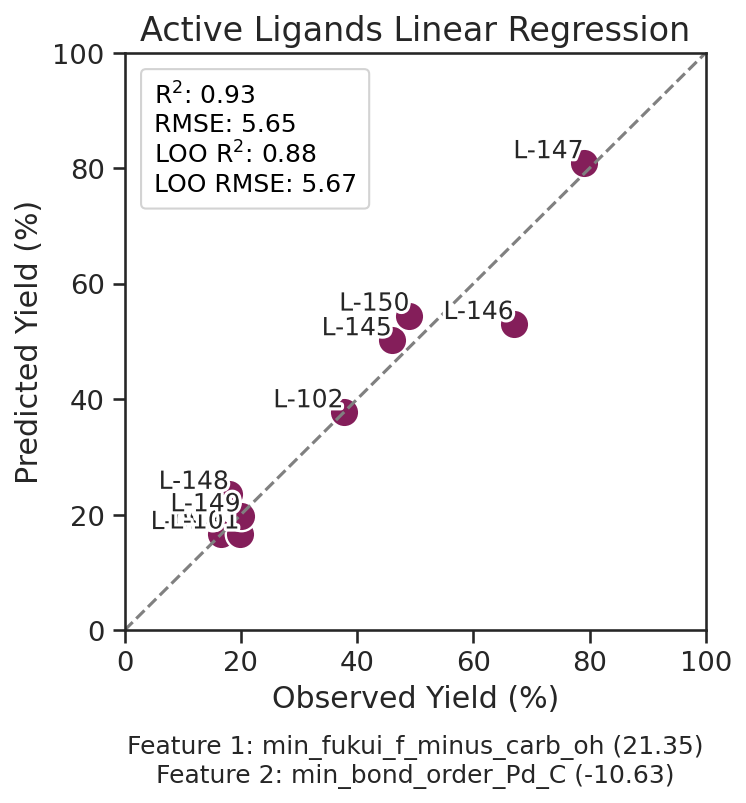

Feature coefficients:
  min_fukui_f_minus_carb_oh: 21.35
  min_bond_order_Pd_C: -10.63


In [7]:
X_feat = X[list(results[0][0])]
# X_feat = X[["max_partial_charge_avg_amine_proton", "max_bond_order_Pd_C"]]
clf = LinearRegression()
evaluate_model(clf, X_feat, y)

print("Feature coefficients:")
coefficients = sorted(zip(X_feat.columns, clf.coef_), key=lambda x: abs(x[1]), reverse=True)
for feature, coefficient in coefficients:
    print(f"  {feature}: {coefficient:0.2f}")

L-147


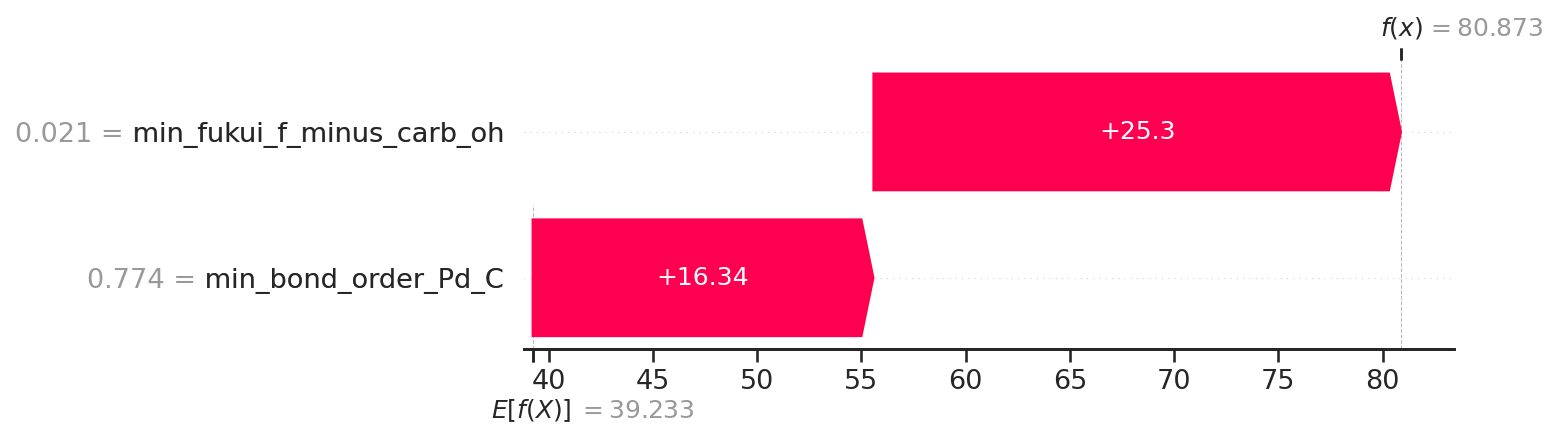

In [12]:
import shap

X_inv = pd.DataFrame(scaler.inverse_transform(X), columns=X.columns)
X_feat_inv = X_inv[X_feat.columns]

clf.fit(X_feat, y)
explainer = shap.explainers.LinearExplainer(clf, X_feat)
shap_values = explainer(X_feat)
for i, c in enumerate(X_feat.columns):
    shap_values.feature_names[i] = c
shap_values.data = X_feat_inv.values

print(df.ligand_1_name.values[-4])
shap.plots.waterfall(shap_values[-4])